In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
from tqdm.notebook import tqdm
import pandas as pd
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Fix a problem with easyocr, the kernel dies without this line
import easyocr
import cv2
import numpy as np
import fasttext
import torchvision
from models.models import *
from utils.utils import *
import pickle


### Preparing models and embedding

In [61]:
path_fasttext = None
path_model = r"C:\Users\Joan\Desktop\Deep learning project 2\positional_encoding_changed.pkl"
criterion = nn.CrossEntropyLoss()

#### Loading the model

In [3]:
with open(path_model, 'rb') as f:
    data_model = pickle.load(f)
state_dict = data_model['model_weights']
config = data_model['parameters']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Transformer_positional_encoding_not_learned(num_classes=config["classes"], depth_transformer=config["depth"], heads_transformer=config["heads"], dim_fc_transformer=config["fc_transformer"]).to(device)
model.load_state_dict(state_dict)
model.eval()

Transformer_positional_encoding_not_learned(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permu

##### Reference for the labels

In [4]:
label2class = {1: "Bakery",
10:"Dry Cleaner",
11:"Funeral",
12:"Hotspot",
13:"MassageCenter",
14:"MedicalCenter",
15:"PackingStore",
16:"Pawnshop",
17:"PetShop",
18:"Pharmacy",
19:"Pizzeria",
2:"Barber",
20:"RepairShop",
21:"Restaurant",
22:"School",
23:"SteakHouse",
24:"Tavern",
25:"TeaHouse",
26:"Theatre",
27:"Tobacco",
28:"Motel",
3:"Bistro",
4:"Bookstore",
5:"Cafe",
6:"ComputerStore",
7:"CountryStore",
8:"Diner",
9:"DiscounHouse"}

#### Transformations aplied to images passed

In [5]:
input_size = 224
imgs_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(236, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
            torchvision.transforms.CenterCrop(input_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#### Inizializing word embedding and easy ocr 

In [6]:
detector = easyocr.Reader(['en'])

In [62]:
if path_fasttext != None:
    w2v = fasttext.load_model(path_fasttext)
else:
    w2v = api.load('glove-wiki-gigaword-300')
    vocab = set(w2v.key_to_index.keys())

### Predicting images

In [57]:
def extract_text_vectors_image(ocr_detector, emb, image, max_n_words=40, dim_w2v=300, fasttext=False):
    image = cv2.GaussianBlur(image, (3,3), 0)
    text_detected = ocr_detector.readtext(image)
    list_text = [token[1] for token in text_detected]
    words = np.zeros((max_n_words, dim_w2v))
    text_mask = np.ones((max_n_words,), dtype=bool)
    i = 0
    for word in list(set(list_text)):
        if len(word) > 2:
            if fasttext:
                if i < max_n_words: # Comented when using glove
                    words[i,:] = emb.get_word_vector(word.lower())  # Comented when using glove
                    text_mask[i] = False
                    i += 1
            else:
                if (word.lower() in vocab) and (i < max_n_words): # Comented when using fasttext
                    words[i,:] = emb[word.lower()] # Comented when using fasttext
                    text_mask[i] = False
                    i += 1
           
    return words, text_mask

In [9]:
def predict_image_class(model, emb, ocr_detector, image_path, label2class, fasttext=False):
    img_rgb =  cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    words, text_mask = extract_text_vectors_image(ocr_detector, emb, img_rgb, max_n_words=40, dim_w2v=300, fasttext=fasttext)
    im_pil = Image.fromarray(img_rgb)
    img = imgs_transform(im_pil)
    img = img.unsqueeze(0).to(device)
    words = torch.tensor(words).float().unsqueeze(0).to(device)
    text_mask = torch.tensor(text_mask).bool().unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img, words, text_mask).cpu()
    probabilities = torch.softmax(output, dim=1)
    prob, pred = torch.max(probabilities, 1)

    prob = prob.to("cpu").numpy()[0]
    prob = round(prob*100, 1)
    plt.title("Predicted: "+ str(label2class[int(pred.to("cpu").numpy())+1]) + " (" + str(prob) + ")", color="black")

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    return probabilities

In [72]:
def top_3_classes(probabilities, label2class):
    data_probabilities_and_class = (torch.topk(probabilities, 3))
    probs = data_probabilities_and_class[0].numpy()[0]
    probs = [round(prob*100, 1) for prob in probs]
    classes = data_probabilities_and_class[1].numpy()[0]
    classes = [label2class[int(classe)+1] for classe in classes]

    for classe, prob in zip(classes, probs):
        print(classe, prob)

    return classes[0]

#### Visualizing where the model focus (Functions)

In [65]:
import cv2
def get_grad_cam(img, txt, txt_mask, label, loss):
    model.zero_grad()
    output = model(img, txt, txt_mask)
    loss = loss(output, label.unsqueeze(0))
    loss.backward()

    img = img = img.reshape(3, 224, 224)
    img = de_normalize(img)
    img = img.permute(1, 2, 0).cpu().numpy() 
    img -= img.min()
    img = (img / img.max()) * 255

    gradients = model.feature_extractor[0][0][0].weight.grad.cpu().numpy()
    activations = model.feature_extractor[0][0][0].weight.cpu().detach().numpy()

    importance_weights = np.mean(gradients * activations, axis=(1, 2))

    cam = np.sum(np.abs(importance_weights[:, np.newaxis, np.newaxis]) * activations, axis=0)
    cam = cam.transpose((1, 2, 0))

    cam_normalized = cv2.resize(cam, (224, 224))
    cam_normalized = np.maximum(cam_normalized, 0)
    cam_normalized = cam_normalized / cam_normalized.max()
    cam_normalized = cam_normalized * img
    cam_normalized = cam_normalized.astype('uint8')
    return cam_normalized

def showGradCam(loss, ocr_detector, emb, image, label, max_n_words=40, dim_w2v=300, fasttext=False, cmap = "heatmap"):
    img_rgb =  cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    words, text_mask = extract_text_vectors_image(detector, emb, img_rgb, max_n_words=40, dim_w2v=300, fasttext=fasttext)
    im_pil = Image.fromarray(img_rgb)
    img = imgs_transform(im_pil)
    img = img.unsqueeze(0).to(device)
    words = torch.tensor(words).float().unsqueeze(0).to(device)
    text_mask = torch.tensor(text_mask).bool().unsqueeze(0).to(device)

    fig, ax  = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [1, 1.25]})
    grad_cam = get_grad_cam(img, words, text_mask, label, loss)

    img = img.reshape(3, 224, 224)
    img = de_normalize(img)
    img = img.permute(1, 2, 0).cpu().numpy() 
    img -= img.min()
    img = (img / img.max()) * 255

    if cmap == "coldmap":
        cam = cv2.applyColorMap(grad_cam, cv2.COLORMAP_JET)
        cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    
    elif cmap == "heatmap":
        cam = cv2.applyColorMap(grad_cam, cv2.COLORMAP_HOT)
        cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

    elif cmap == "colors":
        cam = cv2.cvtColor(grad_cam, cv2.COLOR_BGR2RGB)
    
    else:
        cam = grad_cam
    
    ax[0].imshow(img.astype('uint8'))
    ax[1].imshow(cam)
    ax[0].set_title("Image")
    ax[1].set_title("GradCam")
    ax[1].figure.colorbar(ax[1].imshow(cam), ax=ax[1], orientation='vertical', shrink=0.405)
    plt.tight_layout()
    plt.show()

def de_normalize(images):
  t = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                           std=[1/0.229, 1/0.224, 1/0.255])
  
  return t(images)

## Showing models predictions on images outside the dataset:

An image of The UAB Escola de enginyeria:

In [110]:
image_path = r"C:\Users\Joan\Desktop\Deep learning project 2\dlnn-project_ia-group_15\Photos_test\escola_enginyeria.jpg"

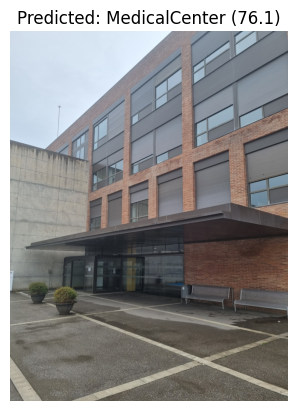

MedicalCenter 76.1
School 21.4
Motel 1.1


In [111]:
use_fasttext = path_fasttext != None # True if using fasttext, False if using glove

probabilities = predict_image_class(model, w2v, detector, image_path, label2class, fasttext=use_fasttext)
most_probable_class = top_3_classes(probabilities, label2class)

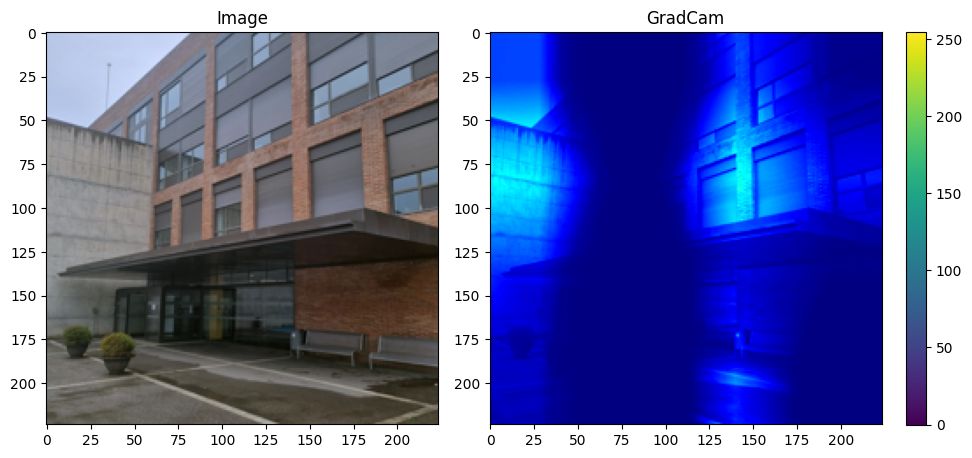

In [112]:
label = {v:k for k, v in label2class.items()}[most_probable_class]
showGradCam(criterion, detector, w2v, image_path, label=torch.tensor(label).to(device), fasttext=use_fasttext, cmap="coldmap")

A pharmacy image

In [113]:
image_path = r"C:\Users\Joan\Desktop\Deep_Learning_project\dlnn-project_ia-group_15\Photos_test\farmacia.jpeg"

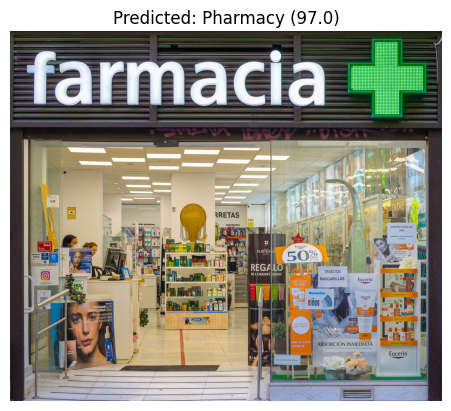

Pharmacy 97.0
PackingStore 0.6
ComputerStore 0.6


In [114]:
probabilities = predict_image_class(model, w2v, detector, image_path, label2class, fasttext=use_fasttext)
most_probable_class = top_3_classes(probabilities, label2class)

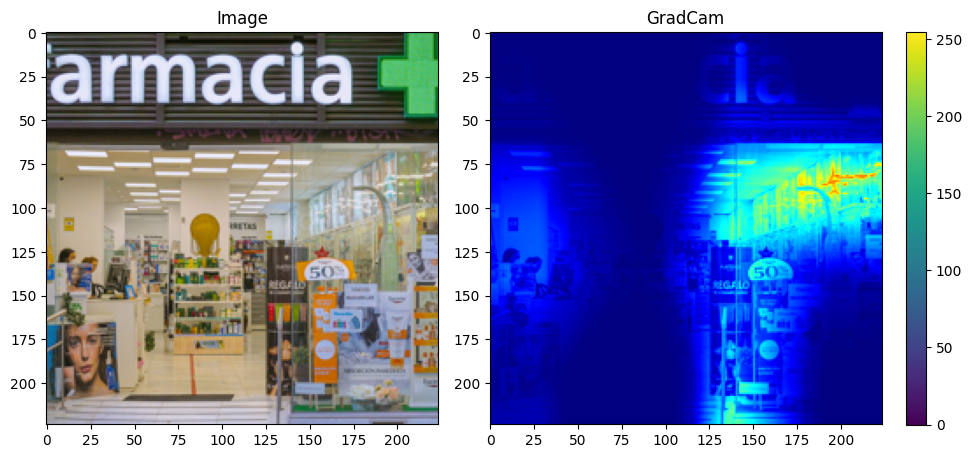

In [115]:
label = {v:k for k, v in label2class.items()}[most_probable_class]
showGradCam(criterion, detector, w2v, image_path, label=torch.tensor(label).to(device), fasttext=use_fasttext, cmap="coldmap")

Examples of Restaurant images

In [116]:
image_path = r"C:\Users\Joan\Desktop\Deep_Learning_project\dlnn-project_ia-group_15\Photos_test\restaurant_exterior.jpg"

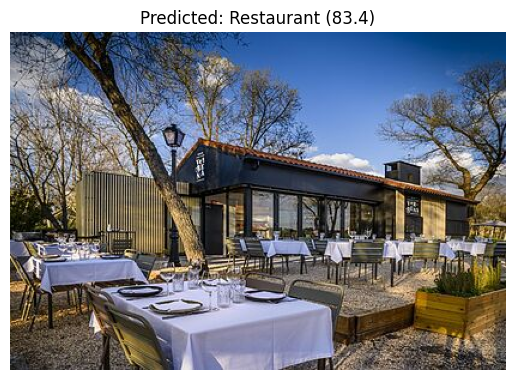

Restaurant 83.4
Bistro 9.9
Cafe 1.9


In [117]:
probabilities = predict_image_class(model, w2v, detector, image_path, label2class, fasttext=use_fasttext)
most_probable_class = top_3_classes(probabilities, label2class)

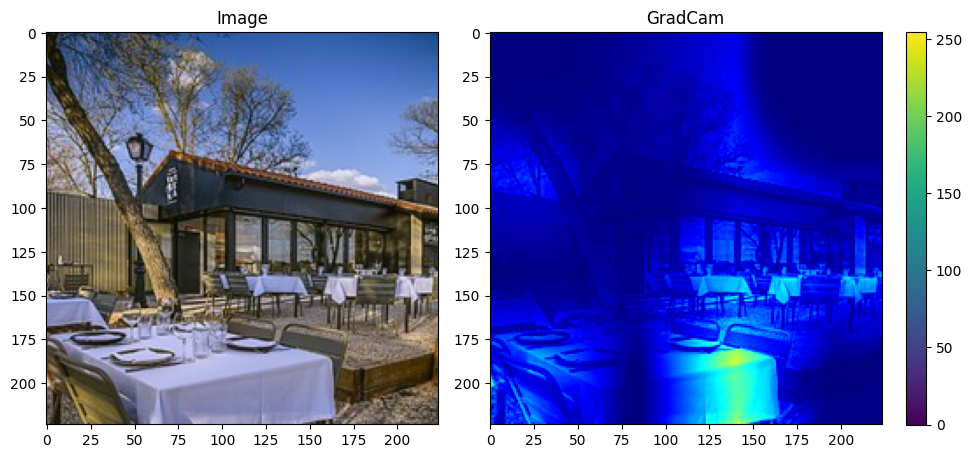

In [118]:
label = {v:k for k, v in label2class.items()}[most_probable_class]
showGradCam(criterion, detector, w2v, image_path, label=torch.tensor(label).to(device), fasttext=use_fasttext,cmap="coldmap")

In [119]:
image_path = r"C:\Users\Joan\Desktop\Deep_Learning_project\dlnn-project_ia-group_15\Photos_test\restaurant_interior.jpg"

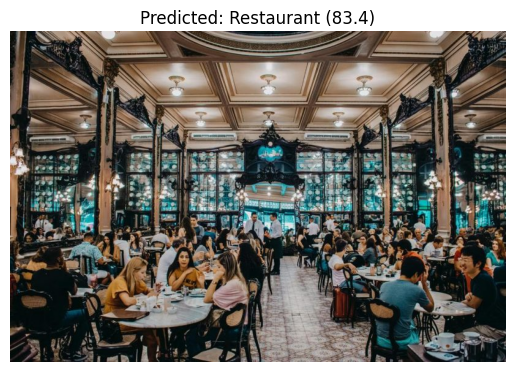

Restaurant 83.4
Bistro 8.1
Cafe 4.0


In [120]:
probabilities = predict_image_class(model, w2v, detector, image_path, label2class, fasttext=use_fasttext)
most_probable_class = top_3_classes(probabilities, label2class)

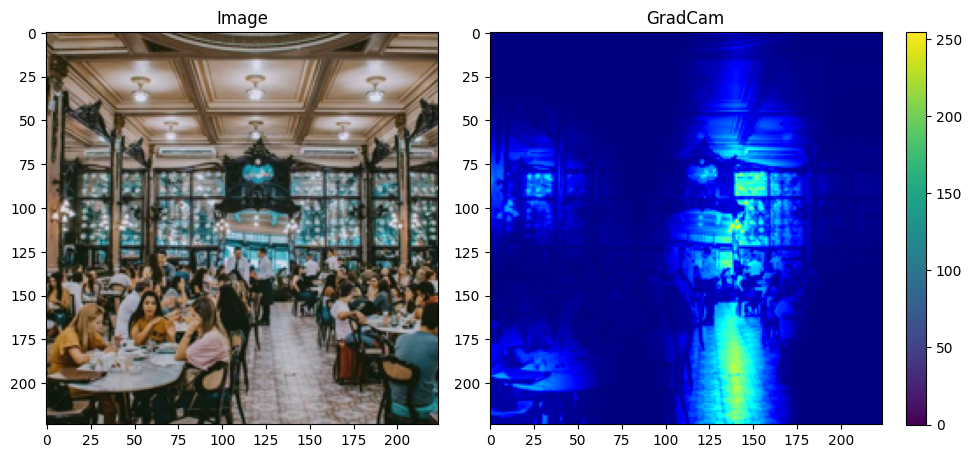

In [121]:
label = {v:k for k, v in label2class.items()}[most_probable_class]
showGradCam(criterion, detector, w2v, image_path, label=torch.tensor(label).to(device), fasttext=use_fasttext,cmap="coldmap")

Example of a pizzeria image

In [122]:
image_path = r"C:\Users\Joan\Desktop\Deep_Learning_project\dlnn-project_ia-group_15\Photos_test\Pizzeria_in_Venice.jpg"

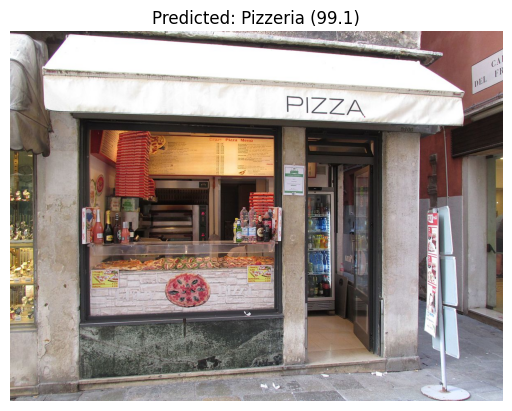

Pizzeria 99.1
Restaurant 0.3
Bakery 0.2


In [123]:
probabilities = predict_image_class(model, w2v, detector, image_path, label2class, fasttext=use_fasttext)
most_probable_class = top_3_classes(probabilities, label2class)

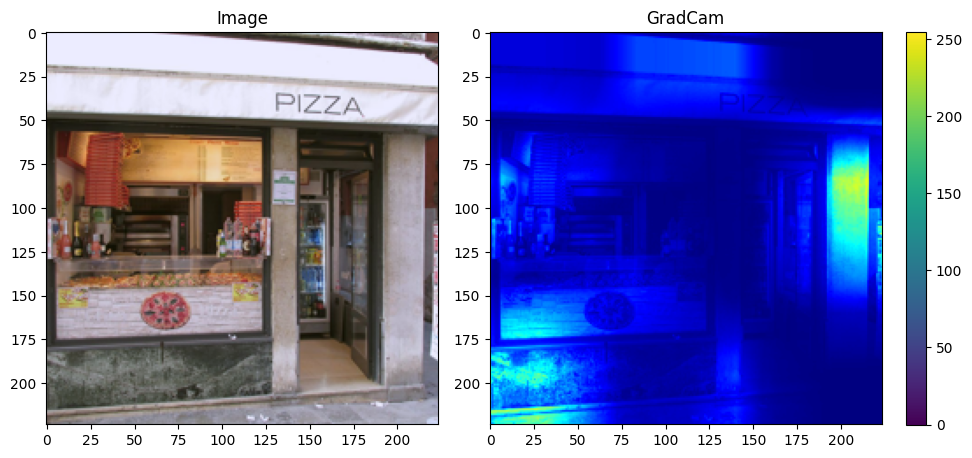

In [124]:
label = {v:k for k, v in label2class.items()}[most_probable_class]
showGradCam(criterion, detector, w2v, image_path, label=torch.tensor(label).to(device), fasttext=use_fasttext,cmap="coldmap")

Example of a barber images

In [125]:
image_path = r"C:\Users\Joan\Desktop\Deep_Learning_project\dlnn-project_ia-group_15\Photos_test\barber_text.jpg"

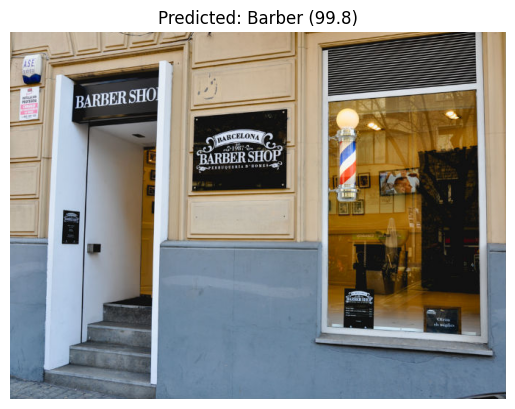

Barber 99.8
Pizzeria 0.0
TeaHouse 0.0


In [126]:
probabilities = predict_image_class(model, w2v, detector, image_path, label2class, fasttext=use_fasttext)
most_probable_class = top_3_classes(probabilities, label2class)

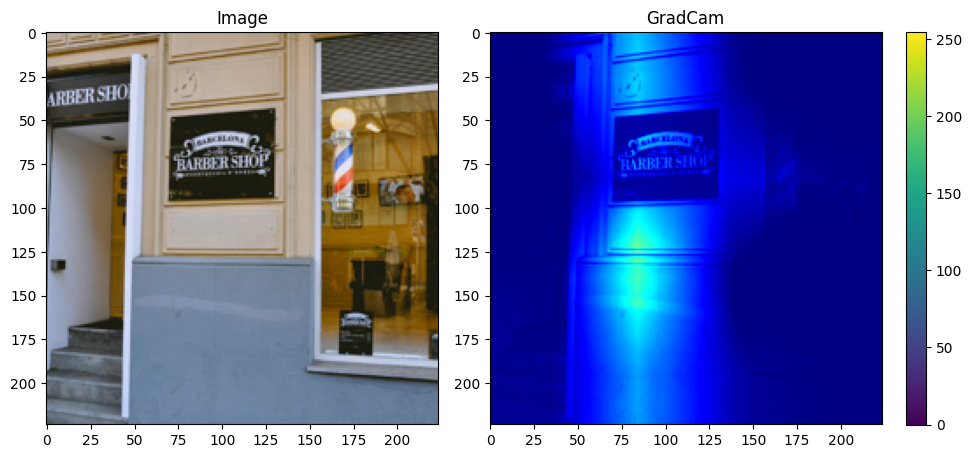

In [127]:
label = {v:k for k, v in label2class.items()}[most_probable_class]
showGradCam(criterion, detector, w2v, image_path, label=torch.tensor(label).to(device), fasttext=use_fasttext,cmap="coldmap")

In [128]:
image_path = r"C:\Users\Joan\Desktop\Deep_Learning_project\dlnn-project_ia-group_15\Photos_test\barber.webp"

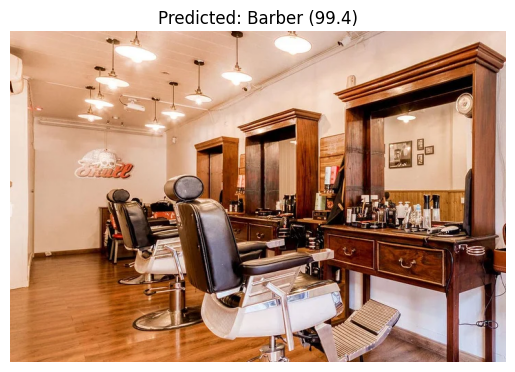

Barber 99.4
RepairShop 0.1
Cafe 0.1


In [129]:
probabilities = predict_image_class(model, w2v, detector, image_path, label2class, fasttext=use_fasttext)
most_probable_class = top_3_classes(probabilities, label2class)

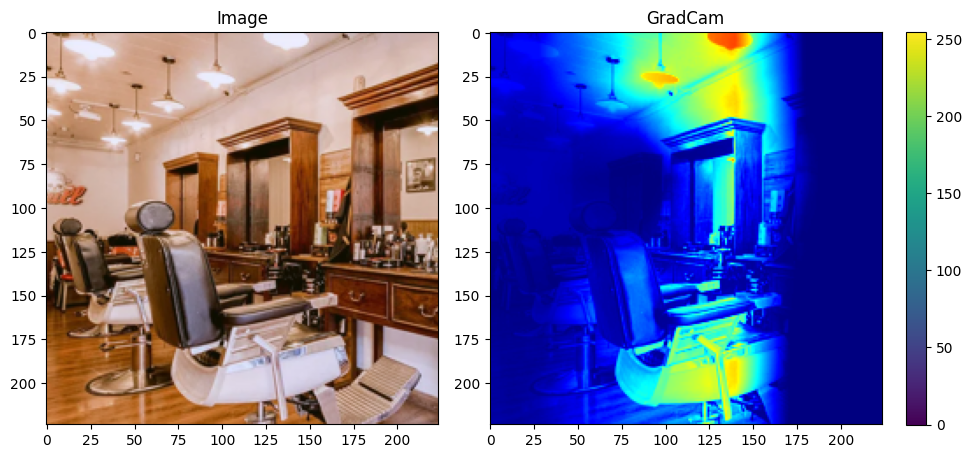

In [130]:
label = {v:k for k, v in label2class.items()}[most_probable_class]
showGradCam(criterion, detector, w2v, image_path, label=torch.tensor(label).to(device), fasttext=use_fasttext,cmap="coldmap")

Examples of bakery imgages

In [131]:
image_path = r"C:\Users\Joan\Desktop\Deep_Learning_project\dlnn-project_ia-group_15\Photos_test\bakery.jpeg"

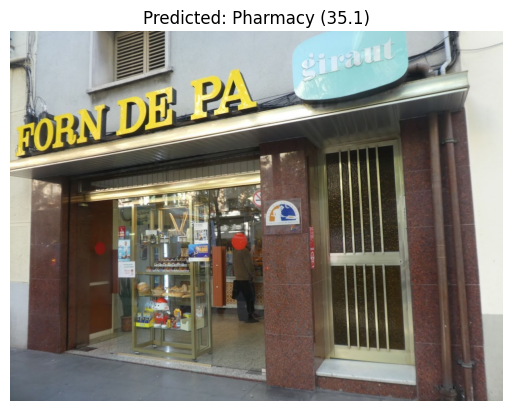

Pharmacy 35.1
PackingStore 20.1
ComputerStore 8.4


In [132]:
probabilities = predict_image_class(model, w2v, detector, image_path, label2class, fasttext=use_fasttext)
most_probable_class = top_3_classes(probabilities, label2class)

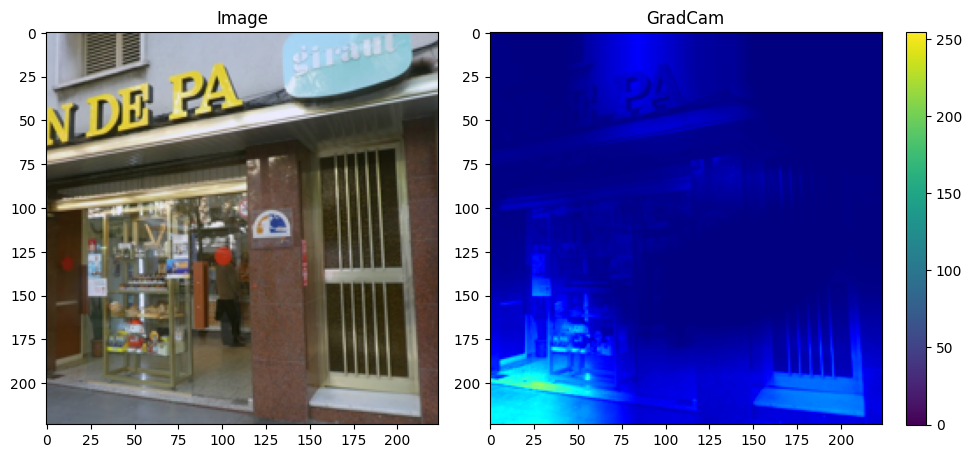

In [133]:
label = {v:k for k, v in label2class.items()}[most_probable_class]
showGradCam(criterion, detector, w2v, image_path, label=torch.tensor(label).to(device), fasttext=use_fasttext,cmap="coldmap")

In [134]:
image_path = r"C:\Users\Joan\Desktop\Deep_Learning_project\dlnn-project_ia-group_15\Photos_test\bakery_spanish.jpg"

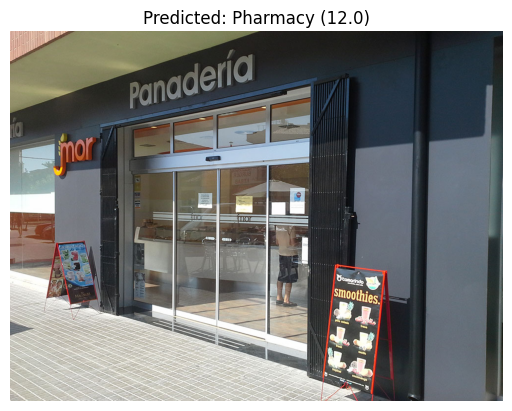

Pharmacy 12.0
PackingStore 11.7
Pawnshop 8.9


In [135]:
probabilities = predict_image_class(model, w2v, detector, image_path, label2class, fasttext=use_fasttext)
most_probable_class = top_3_classes(probabilities, label2class)

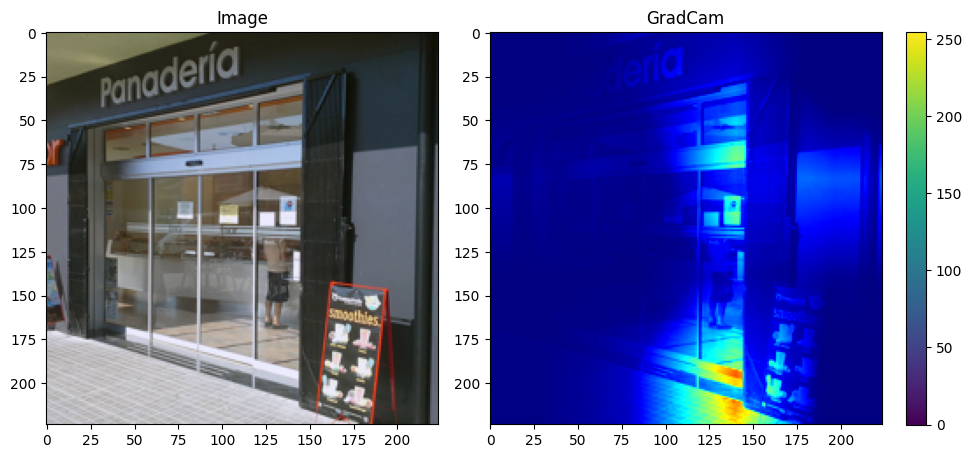

In [136]:
label = {v:k for k, v in label2class.items()}[most_probable_class]
showGradCam(criterion, detector, w2v, image_path, label=torch.tensor(label).to(device), fasttext=use_fasttext,cmap="coldmap")